In [30]:
####################### XGBoost scripts adapted from:
#### https://www.datacamp.com/tutorial/xgboost-in-python
#### https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
#### https://medium.com/@24littledino/xgboost-classification-in-python-f29cc2c50a9b
#### https://www.kaggle.com/code/wongguoxuan/eda-pca-xgboost-classifier-for-beginners

### Install XBoost
#%pip install --user xgboost
#%pip install optuna
%pip install plotly==5.14.1

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.3 MB 17.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import seaborn as sns
import os
import sklearn
import optuna

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
### set work directory
os.chdir("/pscratch/sd/j/jdyuzon/snakemake-bacteriophage2")

In [4]:
### Load same dataset from the Random Forest: use same data for different models to compare performance 
X_train = pd.read_csv('prediction_out/random_forest/X_train.csv')
X_test = pd.read_csv('prediction_out/random_forest/X_test.csv')
y_train = pd.read_csv('prediction_out/random_forest/y_train.csv')
y_test = pd.read_csv('prediction_out/random_forest/y_test.csv')

y_train=y_train['type']
y_test=y_test['type']
y_train=pd.to_numeric(y_train)
y_test=pd.to_numeric(y_test)

X_train.drop(columns=['Unnamed: 0'])

,COG0009,COG0025,COG0027,COG0030,COG0031,COG0034,COG0037,COG0103,COG0116,COG0118,...,TIGR04517,TIGR04528,TIGR04548,TIGR04551,TIGR04558,TIGR04559,TIGR04563,TIGR04565,TIGR04569,TIGR04571
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y_train

0       1
1       1
2       1
3       1
4       0
       ..
1549    1
1550    0
1551    0
1552    1
1553    1
Name: type, Length: 1554, dtype: int64

In [6]:
### XGBoost tries to minimize loss with each round but this doesnt mean loss always goes down
### Early Stopping stops the training if validation loss doesn't improve after the specified number of rounds
xgb_classifier = xgb.XGBClassifier(eta = 0.7,
                                   n_estimators=1000,
                                   tree_method='hist') # 0.7 learning rate, 1000 boosting rounds
xgb_classifier.fit(X_train.drop(columns=['Unnamed: 0']), y_train,
                  eval_set=[(X_train.drop(columns=['Unnamed: 0']), y_train), (X_test.drop(columns=['Unnamed: 0']), y_test)],
                  early_stopping_rounds=50,
                  verbose=10)

[0]	validation_0-logloss:0.23365	validation_1-logloss:0.24853
[10]	validation_0-logloss:0.01409	validation_1-logloss:0.05268
[20]	validation_0-logloss:0.01336	validation_1-logloss:0.05453
[30]	validation_0-logloss:0.01331	validation_1-logloss:0.05462
[40]	validation_0-logloss:0.01331	validation_1-logloss:0.05461
[50]	validation_0-logloss:0.01331	validation_1-logloss:0.05461
[59]	validation_0-logloss:0.01331	validation_1-logloss:0.05461


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.7, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [7]:
# Training score (accuracy) for test data
xgb_classifier.score(X_train.drop(columns=['Unnamed: 0']), y_train)

0.9980694980694981

In [8]:
# Test score (accuracy) for test data
xgb_classifier.score(X_test.drop(columns=['Unnamed: 0']), y_test)

0.9826589595375722

In [9]:
### Model performance
y_pred_test = xgb_classifier.predict(X_test.drop(columns=['Unnamed: 0']))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        72
           1       0.99      0.99      0.99       447

    accuracy                           0.98       519
   macro avg       0.97      0.95      0.96       519
weighted avg       0.98      0.98      0.98       519



In [10]:
# Convert the model to a native API model
xgb_classifier_model = xgb_classifier.get_booster()

In [11]:
### The dataset is small, and splitting the data into train, test, validate will make the training set sparse
### Cross-valdiation has two sets: training and test. However, the training set is split into k folds and the model is trained k times
dtrain_clf = xgb.DMatrix(X_train.drop(columns=['Unnamed: 0']), y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test.drop(columns=['Unnamed: 0']), y_test, enable_categorical=True)
params = {"objective": "binary:logistic", "tree_method": "hist","eta":0.1}
n = 1000

results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   verbose_eval=10,
   early_stopping_rounds=50
)

[0]	train-logloss:0.60150+0.00049	test-logloss:0.60190+0.00097
[10]	train-logloss:0.19280+0.00166	test-logloss:0.19869+0.00871
[20]	train-logloss:0.08046+0.00243	test-logloss:0.09087+0.01355
[30]	train-logloss:0.04281+0.00266	test-logloss:0.05685+0.01878
[40]	train-logloss:0.02910+0.00230	test-logloss:0.04652+0.02358
[50]	train-logloss:0.02220+0.00210	test-logloss:0.04061+0.02456
[60]	train-logloss:0.01888+0.00193	test-logloss:0.03783+0.02548
[70]	train-logloss:0.01732+0.00178	test-logloss:0.03624+0.02536
[80]	train-logloss:0.01659+0.00165	test-logloss:0.03527+0.02527
[90]	train-logloss:0.01639+0.00163	test-logloss:0.03494+0.02555
[100]	train-logloss:0.01626+0.00163	test-logloss:0.03481+0.02573
[110]	train-logloss:0.01618+0.00163	test-logloss:0.03468+0.02580
[120]	train-logloss:0.01612+0.00164	test-logloss:0.03463+0.02584
[130]	train-logloss:0.01608+0.00165	test-logloss:0.03458+0.02585
[140]	train-logloss:0.01604+0.00165	test-logloss:0.03455+0.02586
[150]	train-logloss:0.01601+0.00166	

In [12]:
importances = xgb_classifier.feature_importances_
features=X_train

In [13]:
### Feature importance based on GINI/Mean Decrease in Impurity (MDI)
feats = {}
for feature, importance in zip(X_train, xgb_classifier.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances[0:10]

,Features,Gini-Importance
0,COG3521,0.340860
1,PF05944,0.242724
2,PF06992,0.179421
3,PF17481,0.081037
4,PF18933,0.027160
5,PF09388,0.024678
6,PF14058,0.015306
7,COG3515,0.012297
8,PF19263,0.011238
9,PF06835,0.009390


In [14]:
importances.to_csv('prediction_out/XGBoost/GINI_importances.csv', sep='\t')

In [15]:
### XGBoost with PCA for feature selection
### XGBoost performs very well on medium, small, data with subgroups and structured datasets with not too many features. 

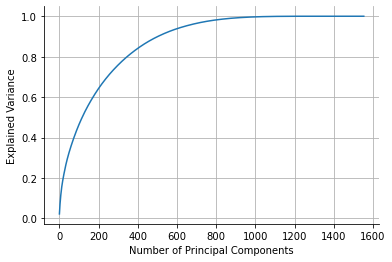

In [16]:
# Before we perform PCA, we need to normalise the features so that they have zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X_train)
train_x_norm = scaler.transform(X_train)

pca = PCA()
comp = pca.fit(train_x_norm)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();

In [17]:
# about 100% of the variance is explained by the first 1000 features 
pca = PCA(n_components=1000).fit(train_x_norm)
train_x_transform = pca.transform(train_x_norm)

# Transform the validation set
test_x_transform = pca.transform(scaler.transform(X_test))

In [18]:
# We create the XGboost-specific DMatrix data format from the numpy array. 
# This data structure is optimised for memory efficiency and training speed
dtrain = xgb.DMatrix(train_x_transform, label=y_train)
dtest = xgb.DMatrix(test_x_transform, label=y_test)

In [38]:
### Tune hyperparameters using Optuna
# The objective function is passed an Optuna specific argument of trial
def objective(trial):
    
# params specifies the XGBoost hyperparameters to be tuned
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 10, 25),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'tree_method': 'gpu_hist',  
        'objective': 'binary:logistic'
    }
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
# trials will be evaluated based on their F1 score on the test set
    f1_score = sklearn.metrics.f1_score(y_test, pred_labels)
    return f1_score

In [39]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=25, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-30 14:54:14,665] A new study created in memory with name: no-name-c8f115df-7d0c-4daf-8f6e-3fdab1c79ae4
[I 2023-05-30 14:54:14,702] Trial 0 finished with value: 0.9843749999999999 and parameters: {'n_estimators': 225, 'max_depth': 24, 'learning_rate': 0.012803731478879745, 'subsample': 0.6189316082137513, 'colsample_bytree': 0.6064105916235938, 'gamma': 0}. Best is trial 0 with value: 0.9843749999999999.
[I 2023-05-30 14:54:14,734] Trial 1 finished with value: 0.9866666666666667 and parameters: {'n_estimators': 600, 'max_depth': 18, 'learning_rate': 0.08398756087697656, 'subsample': 0.7744043422319358, 'colsample_bytree': 0.8908020800870882, 'gamma': 3}. Best is trial 1 with value: 0.9866666666666667.
[I 2023-05-30 14:54:14,760] Trial 2 finished with value: 0.9854748603351955 and parameters: {'n_estimators': 539, 'max_depth': 19, 'learning_rate': 0.0656461142344872, 'subsample': 0.6466510403963448, 'colsample_bytree': 0.6809612037359296, 'gamma': 10}. Best is trial 1 with val

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-30 14:54:14,896] Trial 7 finished with value: 0.9832775919732442 and parameters: {'n_estimators': 353, 'max_depth': 13, 'learning_rate': 0.07462918108228964, 'subsample': 0.5711681221615295, 'colsample_bytree': 0.9991837348628317, 'gamma': 1}. Best is trial 6 with value: 0.9910913140311804.
[I 2023-05-30 14:54:14,920] Trial 8 finished with value: 0.9832775919732442 and parameters: {'n_estimators': 482, 'max_depth': 15, 'learning_rate': 0.05553614032509505, 'subsample': 0.5475003252889192, 'colsample_bytree': 0.9855998486291964, 'gamma': 3}. Best is trial 6 with value: 0.9910913140311804.
[I 2023-05-30 14:54:14,948] Trial 9 finished with value: 0.992196209587514 and parameters: {'n_estimators': 526, 'max_depth': 13, 'learning_rate': 0.09722314103303056, 'subsample': 0.6599765031984872, 'colsample_bytree': 0.5274589673559973, 'gamma': 2}. Best is trial 9 with value: 0.992196209587514.
[I 2023-05-30 14:54:14,994] Trial 10 finished with value: 0.9888641425389755 and parameters: 

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-30 14:54:15,086] Trial 12 finished with value: 0.9910913140311804 and parameters: {'n_estimators': 515, 'max_depth': 21, 'learning_rate': 0.09948395364160051, 'subsample': 0.7403601772431425, 'colsample_bytree': 0.5990607613035862, 'gamma': 0}. Best is trial 9 with value: 0.992196209587514.
[I 2023-05-30 14:54:15,127] Trial 13 finished with value: 0.9877641824249166 and parameters: {'n_estimators': 435, 'max_depth': 11, 'learning_rate': 0.08253354049656579, 'subsample': 0.8304541530289704, 'colsample_bytree': 0.7902194080260159, 'gamma': 4}. Best is trial 9 with value: 0.992196209587514.
[I 2023-05-30 14:54:15,176] Trial 14 finished with value: 0.9899888765294773 and parameters: {'n_estimators': 536, 'max_depth': 16, 'learning_rate': 0.07002434839647124, 'subsample': 0.9981553764175195, 'colsample_bytree': 0.5924940306795531, 'gamma': 2}. Best is trial 9 with value: 0.992196209587514.
[I 2023-05-30 14:54:15,217] Trial 15 finished with value: 0.9832775919732442 and parameters

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-30 14:54:15,344] Trial 18 finished with value: 0.9910913140311804 and parameters: {'n_estimators': 403, 'max_depth': 16, 'learning_rate': 0.09104456532694474, 'subsample': 0.7088108752843758, 'colsample_bytree': 0.553571184374074, 'gamma': 2}. Best is trial 16 with value: 0.9933035714285714.
[I 2023-05-30 14:54:15,388] Trial 19 finished with value: 0.9888392857142857 and parameters: {'n_estimators': 429, 'max_depth': 13, 'learning_rate': 0.07557223709484034, 'subsample': 0.6188799032267345, 'colsample_bytree': 0.5682591266748089, 'gamma': 0}. Best is trial 16 with value: 0.9933035714285714.
[I 2023-05-30 14:54:15,433] Trial 20 finished with value: 0.9888392857142857 and parameters: {'n_estimators': 489, 'max_depth': 10, 'learning_rate': 0.09308693379539004, 'subsample': 0.6799644958151324, 'colsample_bytree': 0.6287943433045512, 'gamma': 1}. Best is trial 16 with value: 0.9933035714285714.
[I 2023-05-30 14:54:15,481] Trial 21 finished with value: 0.991111111111111 and parame

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



[I 2023-05-30 14:54:15,570] Trial 23 finished with value: 0.9877369007803789 and parameters: {'n_estimators': 513, 'max_depth': 14, 'learning_rate': 0.09896177149764199, 'subsample': 0.7136397535329274, 'colsample_bytree': 0.5578301599487, 'gamma': 3}. Best is trial 16 with value: 0.9933035714285714.
[I 2023-05-30 14:54:15,614] Trial 24 finished with value: 0.987709497206704 and parameters: {'n_estimators': 460, 'max_depth': 12, 'learning_rate': 0.07785538468506938, 'subsample': 0.6566538444628345, 'colsample_bytree': 0.504254231571646, 'gamma': 4}. Best is trial 16 with value: 0.9933035714285714.


[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Number of finished trials:  25
Best trial:
  Value: 0.9933035714285714
  Params: 
    n_estimators: 491
    max_depth: 12
    learning_rate: 0.08962139578292777
    subsample: 0.6912685220111162
    colsample_bytree: 0.5220836393385613
    gamma: 1


In [40]:
best_params = trial.params
best_params['tree_method'] = 'gpu_hist' 
best_params['objective'] = 'binary:logistic'

# Fit the XGBoost classifier with optimal hyperparameters
optimal_clf = xgb.XGBClassifier(**best_params)

optimal_clf.fit(train_x_transform, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5220836393385613, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08962139578292777,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=491, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

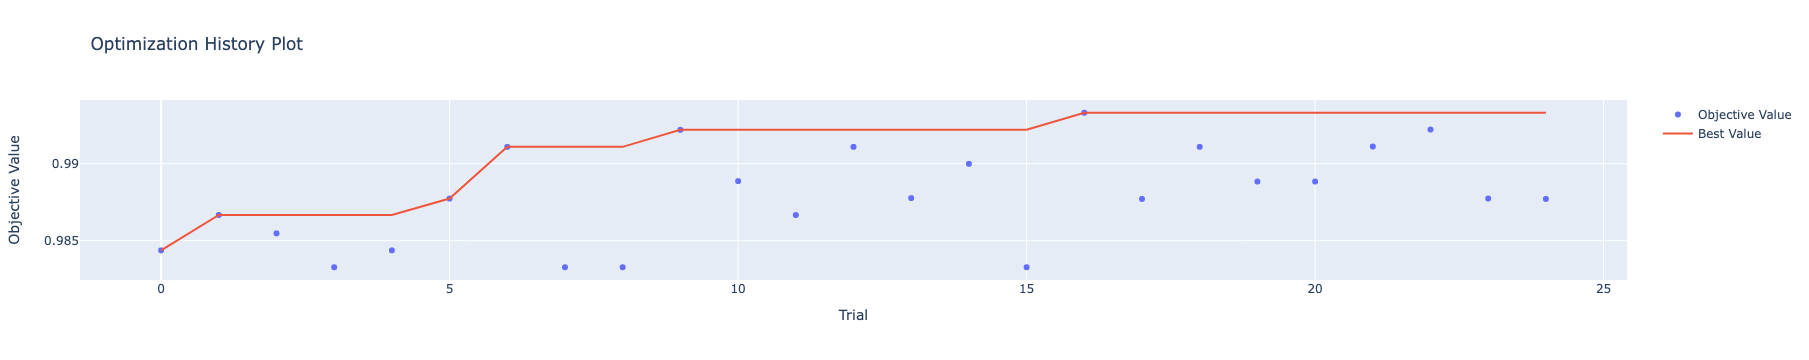

In [41]:
# Plot how the best F1 score evolves with number of trials
fig = optuna.visualization.plot_optimization_history(study)
fig.show();

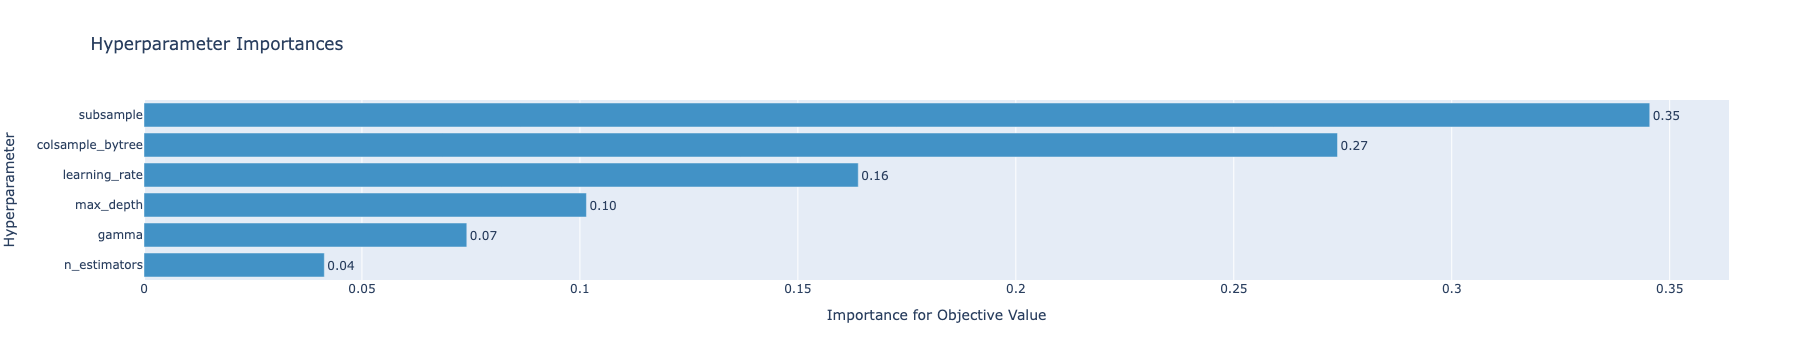

In [42]:
#  plot the relative importance of different hyperparameter settings
fig = optuna.visualization.plot_param_importances(study)
fig.show();
### XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html
# gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. 
# subsample: ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.
# learning_rate/eta: after each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative/prevent overfitting
# max_depth: increasing this value will make the model more complex and more likely to overfit
# colsample_bytree: subsample ratio of columns when constructing each tree.
# n_estimators: number of gradient boosted trees

In [43]:
optimal_clf.score(train_x_transform, y_train)

1.0

In [44]:
# Test score (accuracy) for test data
optimal_clf.score(test_x_transform, y_test)

0.9903660886319846

In [45]:
# View the classification report for test data and predictions
y_pred_test = optimal_clf.predict(test_x_transform)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.99      1.00      0.99       447

    accuracy                           0.99       519
   macro avg       0.98      0.98      0.98       519
weighted avg       0.99      0.99      0.99       519

